# [IAPR][iapr]: Final project - Chocolate Recognition


**Moodle group ID:** *3*
**Kaggle challenge:** *Deep learning*
**Kaggle team name (exact):** "*Byte the Bar*"

**Author 1 (sciper):** Nathann Morand (296190)

**Author 2 (sciper):** David Croce (327277)

**Author 3 (sciper):** Felipe Ramirez (331471)

**Due date:** 21.05.2025 (11:59 pm)


## Key Submission Guidelines:
- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`
- **Only groups of three will be accepted**, except in exceptional circumstances.


[iapr]: https://github.com/LTS5/iapr2025

---

# Introduction
We are tasked to make a program that is able to count how many instance among 13 praline class in a cluttered image.
We must retrain our model from scratch and are provided with only a very limited number of training image (90)
The score is computed using a modified F1 score (that take difference in number of predicted praline)

For our approach we chose to make convolutional model based of the yolo architecture but instead we rewrote the network head to directly predict the number of instance for each class. We named our architecture yoco : you only count once. To train it we chose to make a synthetic dataset generator based of cropped praline from the training dataset pasted on top of the empty background that where extracted.

# Dataset & Preprocessing
The original dataset offer 90 image that are 6000x4000 px, .JPG The image where taken in similar lightning condition and are relatively well lit.
The inference dataset has the same properties.

## EDA
Image from the dataset look like the following with different background object, different miscellaneous object scatter around and a few praline.

<img src="src/dataset/dataset_project_iapr2025/train/L1000957.JPG" width="600" height="400"/>

Using the provided CSV we computed the histogram of number of chocolate per image and the histogram showing the number of instance per class to see how well the class are balanced. We also show how many individual instance of praline are available across the dataset and the maximum number of chocolate of each class present on an image.


Total number of chocolates in the dataset: 584
Maximum number of instances for each chocolate class in a single image:
Jelly White          3
Jelly Milk           3
Jelly Black          3
Amandina             2
Crème brulée         4
Triangolo            3
Tentation noir       4
Comtesse             5
Noblesse             3
Noir authentique     3
Passion au lait      3
Arabia               3
Stracciatella        3
total_chocolates    13
dtype: int64


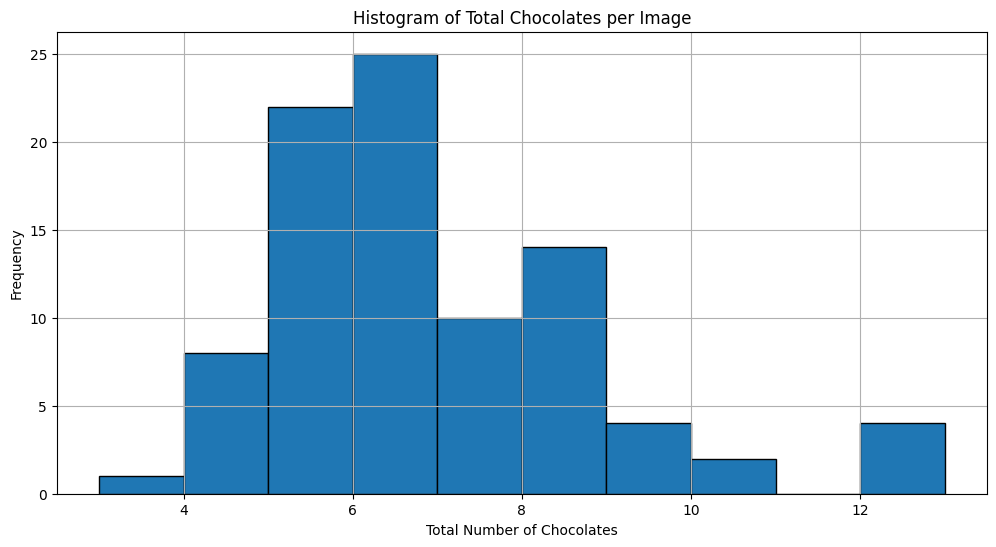

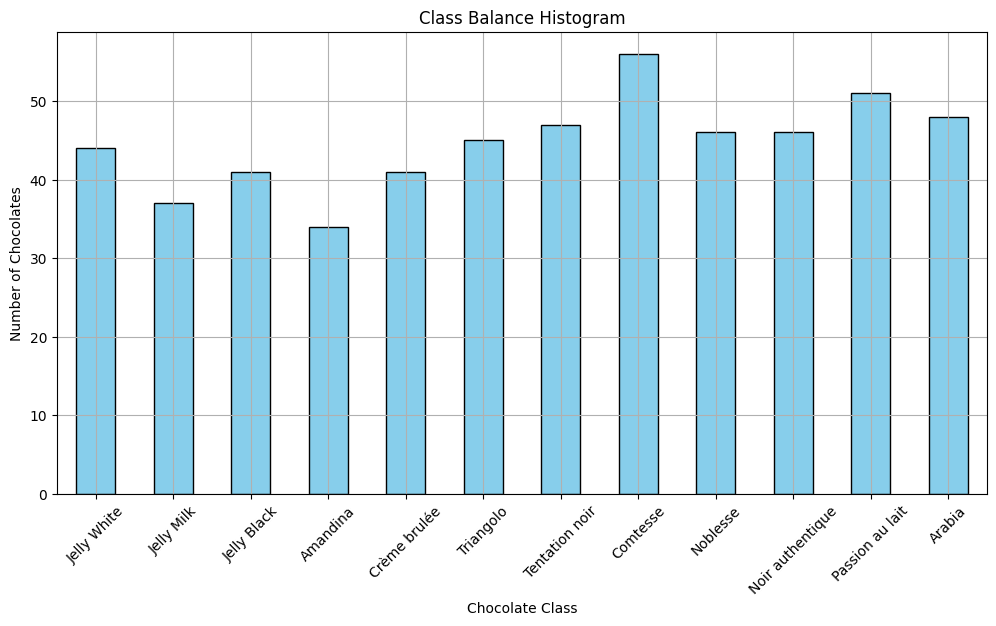

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('src/dataset/dataset_project_iapr2025/train.csv')

# Calculate the total number of chocolates per image
df['total_chocolates'] = df.iloc[:, 1:].sum(axis=1)

# Print the total number of chocolates in the dataset
total_chocolates_in_dataset = df['total_chocolates'].sum()
print(f"Total number of chocolates in the dataset: {total_chocolates_in_dataset}")

# Get the maximum number of instances per class
max_per_class = df.iloc[:, 1:].max()

# Print the results
print("Maximum number of instances for each chocolate class in a single image:")
print(max_per_class)

# Plot the histogram for total chocolates per image
plt.figure(figsize=(12, 6))
plt.hist(df['total_chocolates'], bins=range(df['total_chocolates'].min(), df['total_chocolates'].max() + 1), edgecolor='black')
plt.title('Histogram of Total Chocolates per Image')
plt.xlabel('Total Number of Chocolates')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the histogram for class distribution (excluding total chocolates column)
class_counts = df.iloc[:, 1:13].sum(axis=0)
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Balance Histogram')
plt.xlabel('Chocolate Class')
plt.ylabel('Number of Chocolates')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



## Instance extraction
To make the synthetic dataset generator, we cropped manually the 583 praline present in the 90 image using a helper script to draw the box and save it in a new file. We made a second helper file to show the image and moving it to the correct folder after the operator write the class id thus making the sorting faster.

Once the praline where cropped we spent many hours cleaning the background from the 584 pralines using paint or Gimp. That being done we made another helper script to re-orient, center and rescale the praline. The recalling factor allowed use to measure the size variation between the praline and thus know that the variation was +-20% and thus a single detection head would be sufficient. We also did the same with the misc object present and patched the hole in the background.

Here are an overview of the cleaned praline :

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define path and ignored folders
base_path = 'chocolate_data/praline_clean'
ignored_folders = {"MiscObjects", "raw_praline", "references", "Background"}

# Get valid subfolders
valid_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f)) and f not in ignored_folders]

# Function to display a 6x6 image mosaic
def display_mosaic(images, title):
    fig, axes = plt.subplots(6, 6, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    for i in range(36):
        ax = axes[i // 6, i % 6]
        if i < len(images):
            ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Process each valid folder
for folder in valid_folders:
    folder_path = os.path.join(base_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files = image_files[:36]  # Limit to first 36 images

    images = []
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((200, 200))
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")

    display_mosaic(images, title=folder)


## Synthetic dataset generation

To train our chocolate detection and counting model, we developed a synthetic dataset generator that creates realistic scenes by compositing high-quality, transparent PNG cutouts of pralines and clutter onto large photographic backgrounds. The generator is designed to mimic natural variations in object placement, orientation, scale, and density while ensuring dataset consistency and coverage across all 13 chocolate classes.

#### Directory Structure

The image assets are organized as follows:

```
src/dataset/
├── praline_clean/
│   ├── <ChocolateClass>/        # 1000x1000 transparent PNGs per class
│   ├── MiscObjects/             # 1000x1000 PNGs of clutter (non-chocolates)
│   └── Background/              # 6000x4000 high-res background images
└── syntheticDataset/
    ├── images/train/            # Generated training images
    ├── images/val/              # Generated validation images
    ├── train.csv                # YOLO-style count labels
    └── val.csv
```

#### Scene Generation Logic

For each synthetic scene, the generator performs the following steps:

1. **Background Selection**: A random high-resolution background (6000×4000 px) is selected.

2. **Misc Object Placement**:
   - Randomly place 0–6 miscellaneous objects per image.
   - Each object receives a random rotation (0–360°) and is scaled with ±20% jitter applied to base scale factors.
   - Objects are not allowed to overlap but may touch. Up to 20 retry attempts are made to find valid positions.

3. **Chocolate Placement**:
   - Each of the 13 chocolate classes is assigned 0–5 instances per image based on a skewed probability distribution favoring 0 or 1.
   - Each chocolate instance is rescaled (with class-specific base factors and jitter), rotated randomly, and placed while checking that overlaps do not exceed 20% with any existing chocolates (touching is allowed).
   - At least one pair of chocolates (if more than two are present) is forced to touch to reflect realistic clutter.

4. **Label Generation**:
   - Labels are saved in CSV format compatible with YOLO count training, with each row representing a synthetic image and columns encoding the number of instances per class.
   - Example:
     ```
     id,Jelly White,Jelly Milk,...,Stracciatella
     1000001,2,1,...,0
     ```

5. **Scene Saving**:
   - The final composite image can optionally be resized using a configurable downscaling factor.
   - Image and corresponding label are saved in the appropriate `train` or `val` directory, based on a configurable split ratio (default: 80/20).

#### Performance & Scalability

- The generator uses multi-threading to parallelize image composition, utilizing `N-2` CPU cores to avoid overloading the system.
- Progress is tracked using `tqdm` to provide live feedback.
- The total number of generated scenes is configurable (default: 10,000), and all key parameters (e.g., scaling jitter, image size, split ratio) can be tuned easily.

#### Result
Using the technique descibed previously we could generate between 5k and 100k picture similar to the following. it's possible to go higher given a bit more of optimisation and more patience

<img src="src/dataset/syntheticDataset/A/images/train/1000000.JPG" width="600" height="400"/>



# Model Architecture

## YOCO Architecture – *You Only Count Once*

### Objective

The **YOCO** family of models is a set of custom convolutional neural networks designed to **predict per-class object counts** in high-resolution images containing chocolate pralines. Instead of performing detection + instance counting, the model directly classifies the **number of instances** for each of the 13 chocolate classes.

We explored several versions of YOCO with varying model capacities:

| Model         | Parameters | Notes                                               |
| ------------- | ---------- |-----------------------------------------------------|
| **YOCOLARGE** | \~9.2M     | Deep residual model to mitigate vanishing gradients |
| **YOCO**      | \~4.0M     | Deep residual model to mitigate vanishing gradients |
| **YOCOSMALL** | \~1.3M     | Simple CNN                                          |

*  YOCOSMALL is a simple convolutional NN with a dense head.
* **YOCO** and **YOCOLARGE** were redesigned with **residual blocks, and wider channels** to improve performance and stability during training, particularly against vanishing gradients that occured when we tried to make YOCOSMALL wider.


## YOCOSMALL Architecture

This is a simple convolutional network with a dense head. It works and the performance is decent (F1 > 0.93) but
since we are very competitive we kept pushing harder and thus ended up with YOCO and YOCOLARGE (described later)

### Feature Extractor

| Layer  | Channels  | Description                       |
| ------ | --------- | --------------------------------- |
| Conv2d | 3 → 16    | Stem                              |
| Conv2d | 16 → 32   | + MaxPool2d                       |
| Conv2d | 32 → 64   |                                   |
| Conv2d | 64 → 128  |                                   |
| Conv2d | 128 → 256 |                                   |
| Conv2d | 256 → 256 | Final feat. map: `[B, 256, 7, 7]` |

### Head

| Layer             | Channels                                    | Notes                |
| ----------------- | ------------------------------------------- | -------------------- |
| Conv2d            | 256 → 128                                   | 3×3 + LeakyReLU(0.3) |
| Conv2d            | 128 → 78                                    | 1×1 output head      |
| AdaptiveAvgPool2d | → `[B, 78, 1, 1]` → reshape to `[B, 13, 6]` |                      |

### Notes:

* Downsampling is performed via max pooling instead of strided convolutions.
* All activations are **LeakyReLU**, unlike the **PReLU** used in YOCOLARGE.
* YOCOSMALL uses smaller channel sizes to reduce parameter count.

## YOCO & YOCOLARGE Architecture

This is a **deep residual CNN** that uses repeated `BasicBlock` modules with **PReLU activations** and skip connections.
These two models follow the **same structure** but YOCOLARGE use **bigger channel sizes**.

### Main Components:

#### 1. Stem

```text
Conv2d(3 → 24) → BatchNorm → PReLU
```

#### 2. Residual Blocks (BasicBlock)

Each block contains two 3×3 convolutions with BatchNorm and PReLU activations. Skip connections are used with optional downsampling:

| Layer  | Input → Output Channels | Downsampling | Output Resolution |
| ------ | ----------------------- | ------------ | ----------------- |
| layer1 | 24 → 48                 | Yes          | 600×400           |
| layer2 | 48 → 96                 | Yes          | 300×200           |
| layer3 | 96 → 192                | Yes          | 150×100           |
| layer4 | 192 → 384               | Yes          | 75×50             |
| layer5 | 384 → 384               | Yes          | 37×25             |
| layer6 | 384 → 384               | Yes          | 18×12             |

#### 3. Head

```text
Conv2d(384 → 256, 3×3) → BatchNorm → PReLU
Conv2d(256 → 13×6 = 78, 1×1)
```

#### 4. Pooling and Output

```text
AdaptiveAvgPool2d(1×1) → Reshape to [B, 13, 6]
```

## Shared Output Format

All models process an RGB image of shape `(3, 800, 1200)` and output a tensor of shape `(13, 6)`, where:

* `13` = number of chocolate classes
* `6` = number of count bins: `[0, 1, 2, 3, 4, 5+]`

Each entry is a **logit vector** representing the likelihood of a specific count.

## Output Format and Count Encoding

For each chocolate class, the model predicts a **one-hot encoded distribution** over 6 count bins:

```text
[0, 1, 2, 3, 4, 5+]
```

Advantages:

* Reflects **discrete** nature of counts.
* More robust than regression.
* Handles upper-bound uncertainty with `5+`.

---

## Shared Loss Function

We use **average cross-entropy loss over all classes**, with **weighted penalty for class 0 (white jelly)** due to its historically poor F1 score:

```python
def compute_loss(outputs, labels, criterion, weight_fp=10.0):
    NUM_CLASSES = outputs.size(1)
    lo = []
    for i in range(NUM_CLASSES):
        if i == 0:
            lo.append(weight_fp*criterion(outputs[:, i, :], labels[:, i]))
        else:
            lo.append(criterion(outputs[:, i, :], labels[:, i]))
    return sum(lo) / NUM_CLASSES
```

## Activation Functions

| Location          | Function                                |
| ----------------- | --------------------------------------- |
| Feature Extractor | LeakyReLU (SMALL) or PReLU (YOCO/LARGE) |
| Head              | LeakyReLU(0.3) or PReLU                 |

as recommended during the lecture

---

## Visual Architecture
here is a graphical representation for the YOCOSMALL architecture.
the other are present in the folder but not here as they are hard to read
![YOCO Architecture](yocoS_arch.png)

---


# Training

### Dataset Split

The dataset was split into **80% training** and **20% validation**.
Since synthetic data generation is no longer a bottleneck, this ratio was chosen for convenience and has **little practical impact on final performance**.
We generated 100k images to train our network but if one want to save time, it's possible to have over 0.9 F1 with as little as 10k images and the yocosmall model.

### Optimization
we used the default choice : Adam
- **Learning Rate:** 1e-3
  - Higher values tested up to 1e⁻2. the loss get a bit jerky but the F1 score remain stable and it generally works quite as good.
  - Lower values (10⁻4) led to extremely slow convergence.

| Parameter     | Value               |
|---------------|---------------------|
| Batch Size    | 8-16 (GPU), 1 (CPU) |
| Epochs        | 20–50               |
| Learning Rate | 1e-3                |
| Optimizer     | Adam                |
| Scheduler     | None                |


### Training Loss Plot

<img src="src/loss.png" width="600" height="400"/>


# Evaluation

### Custom F1-Score Metric

To evaluate the performance of our YOCO (You Only Count Once) model, we where provided with a custom, F1-score like, metric tailored for multi-class object counting.

### Evaluation Process

During training, evaluation was conducted on the **synthetic validation set**, which is structurally similar to the training images but randomly generated. However, to verify the generalization of the model, we also computed the custom F1-score on the **real training images**. This helped test whether the model overfit to synthetic artifacts or learned transferable features.

### Quantitative Results

**F1 Scores per Class:**

| Class              | F1 Score |
|--------------------|----------|
| Jelly_White        | 0.9362   |
| Jelly_Milk         | 0.9737   |
| Jelly_Black        | 0.9756   |
| Amandina           | 0.9697   |
| Crème_brulée       | 1.0000   |
| Triangolo          | 1.0000   |
| Tentation_noir     | 1.0000   |
| Comtesse           | 1.0000   |
| Noblesse           | 1.0000   |
| Noir_authentique   | 1.0000   |
| Passion_au_lait    | 1.0000   |
| Arabia             | 1.0000   |
| Stracciatella      | 0.9897   |

**Global F1 Score:** **0.9865**


> The lower F1 scores observed for the *Jelly* series may be due to their **reflective surfaces**, which cause inconsistent appearances under lighting variation. We hypothesize that modifying the synthetic generator to include **color jittering + smoothing of the color with the background** could improve performance further.

### Visual Evaluation

Visual comparison between predictions and ground truth on real images was performed manually. However, due to the counting-only nature of the model and absence of bounding boxes, typical detection visualizations (e.g., masks or heatmaps) are not applicable. The results confirmed that the model is **visually accurate** in object presence and counts, particularly on well-lit and non-reflective samples.


# Inference on Original Images & Result
We made a script that load a checkpoint and run inference on the testing dataset and format the result in a CSV for kaggle.
It also recomputes the F1 score per class using the real image from the training dataset + provided CSV.
Since we don't like surprise we manually checked our best prediction to see if there was any difference between the training and testing F1 score.
- Show per-image table: `image ID | GT counts | Predicted counts | F1`



# Discussion & Limitations
- The model perform overall very well. there is not much difference in F1 score between the classes either so there are not many low-hanging fruit left to pick.
- We spend a significant amount of time trying different architecture, width and depth because it's fun but YOCOSMALL would have been sufficient in the context of this class. We learned many things by doing so.
- The synthetic dataset generator was probably the key to success. We never bothered to try with only the 90 images provided but believe that performance would have been quite limited and that F1>0.88 or so would be hard to reach even with good augmentation.
- except for the manual detouring of the 584 chocolates, this project was very fun and rewarding.
- We tried model ensembling by training 3 model from 3 different dataset but this had very little effect compared to just making more synthetic images.
- If we had more time / patience and more GPU It would have been nice to test the effect of different optimiser and more network topology (Pooling layer, parameters of the conv, width, dept, ...)
- Some result where unepected like the fact that the 4M model would outperform the bigger model but the difference is small and could be due to luck.
- We also noticed that the bigger the dataset, the less epoch are required but this is to be expected.
- there ise a threshold in the number of training image under which the model overfit. In our case, it's close to 1000 images.
- Annealing might have improved thing a bit further as it would allow the model to converge even closer to the minimum but was not attempted.

## Appendix

### Development Log – What We Tried

This project went through several phases of experimentation. Here's a chronological overview of the different approaches we explored, with some thoughts on each one:

1. **Autoencoder**
   Our first (slightly naïve) attempt was to use an autoencoder, without fully understanding how it might work in the context of object counting. The idea was to reconstruct the image and spot anomalies that might correspond to pralines. Unsurprisingly, this didn’t yield meaningful results.

2. **Ultralytics YOLO**
   We then tried something more out-of-the-box: **Ultralytics YOLO**, using a pretrained model fine-tuned on our data. While promising at first, we realised later on that it was not allowed due to requiring the Ultralytics package.

3. **Classical Machine Learning**
   We also explored traditional ML methods (like regressions, k-NN, and random forests) using handcrafted features from the images. As expected, without  feature extraction or spatial context and due to skill issue, the models struggled to generalize and offered only limited performance. We did find a stupid heuristic that almost reach the baseline but the real world usage of such a solution remain unclear.

4. **YOLOv1 Reimplementation in PyTorch**
   To get a better grasp of the detection pipeline, we reimplemented **YOLOv1 from scratch in PyTorch**. This helped us understand how detection and classification interact, and gave us more control over the architecture and training process.

5. **YOCO – “You Only Count Once” (Custom Model)**
   Building on our previous attempts, we designed our own architecture specifically for **multi-class counting without localization**. Our model, YOCO, features a custom prediction head that outputs, for each class, a distribution over 6 count bins (0 to 5+).
   Although inspired by YOLO in principle (for the convolution part), this model was built entirely from scratch and tailored to our needs: high-resolution image input, accurate per-class counts, and no bounding boxes.

6. **YOCOLARGE**
   To combat vanishing gradient as we tried to make the model wider and deeper we implemented a more complex architecture

# Disclaimer
The majority of the code and of this report where made using AI tools. for detailed prompt, they are at the beginning of each script and also serve as documentation to the script working and usage.

# Bonus

Although we competed for the ML challenge, we also came up with a simple solution for the classical challenge by doing simple statistics on the training label only.
We made a script to find the "universal" answer that would yield the highest F1 score in O(1) time and thus managed to reach F1 of ~0.4 by always predictive 1 for the number of instance for the 13 class. Although of little practical use we found it original, funny and stupid enough to deserve a mention here.